In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_excel("data/편의점 데이터 2017.xlsx")

In [3]:
data

거래번호  순번         대분류     중분류                상품명    가격  수량  판매금액  \
0          3   1       drink      차류        광동)헛개차500ML  1500   1  1500   
1          4   1       drink      커피   칠성)칸타타아메리카노175ML  1200   1  1200   
2          5   1  Fresh Food       빵          브랑)고구마소보로  1200   1  1200   
3          5   2       drink  소프트드링크   풀무원)아임리얼토마토190ML  2900   1  2900   
4          6   1       drink      생수  코레버)행복할수500ML(진로)   500   1   500   
...      ...  ..         ...     ...                ...   ...  ..   ...   
150201   306   5       Snack      스낵   제이)씨네마팝콘카라멜맛2000  2000   1  2000   
150202   307   1       drink      생수        농심)백산수500ml   800   1   800   
150203   308   1       drink  소프트드링크     동아)포카리스웨트500ML  2000   1  2000   
150204   308   2       Snack      스낵       해태)허니버터칩1500  1500   1  1500   
150205   308   3       Snack      스낵        농심)포테토칩1500  1500   1  1500   

               일시 weekday  holiday season  
0      2017-01-01     Sun        1    win  
1      2017-01-01     Sun        1    win  
2      2017-01-01     Sun        1    win  
3      2017-01-01     Sun        1    win  
4      2017-01-01     Sun        1    win  
...           ...     ...      ...    ...  
150201 2017-12-31     Sun        1    win  
150202 2017-12-31     Sun        1    win  
150203 2017-12-31     Sun        1    win  
150204 2017-12-31     Sun        1    win  
150205 2017-12-31     Sun        1    win  

[150206 rows x 12 columns]

In [4]:
data_gr = data.groupby("일시").sum()

In [5]:
data_gr

거래번호    순번      가격   수량     판매금액  holiday
일시                                                    
2017-01-01  52174   677  772550  453   868000      405
2017-01-02  46065   863  721850  480   855470        0
2017-01-03  27168   684  488550  322   514250        0
2017-01-04  22483   517  479900  335   604920        0
2017-01-05  19412   429  445900  289   514920        0
...           ...   ...     ...  ...      ...      ...
2017-12-27  25397   508  486640  374   663052        0
2017-12-28  29779   603  569750  383   609940        0
2017-12-29  71591  1099  863890  595  1013560        0
2017-12-30  94193  1274  947850  711  1068304      621
2017-12-31  85923  1136  867760  656   960340      568

[363 rows x 6 columns]

In [6]:
uni_data = data_gr["판매금액"]

In [7]:
uni_data

일시
2017-01-01     868000
2017-01-02     855470
2017-01-03     514250
2017-01-04     604920
2017-01-05     514920
               ...   
2017-12-27     663052
2017-12-28     609940
2017-12-29    1013560
2017-12-30    1068304
2017-12-31     960340
Name: 판매금액, Length: 363, dtype: int64

In [8]:
uni_data = uni_data.values

In [9]:
uni_data.shape

(363,)

In [10]:
TRAIN_SPLIT = 300
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std


In [11]:
def univariate_data(dataset, start_index, end_index, history_size, target_size, target_range):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_range

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        if target_range:
            labels.append(dataset[i:i+target_range])
        else:
            labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [12]:
univariate_past_history = 15
univariate_future_target = 1
univariate_future_range = 5
TRAIN_SPLIT = 300
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target,univariate_future_range)

In [13]:
x_train_uni.shape

(285, 15, 1)

In [14]:
y_train_uni.shape

(285, 5)

In [15]:
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target, univariate_future_range)

In [16]:
BATCH_SIZE = 30
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [306]:
train_univariate

<RepeatDataset shapes: ((None, 15, 1), (None, 5)), types: (tf.float64, tf.float64)>

In [307]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(5)
])

In [308]:
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [309]:
EVALUATION_INTERVAL = 500
EPOCHS = 5

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 500 steps, validate for 50 steps
Epoch 1/5
500/500 [==============================] - 7s 13ms/step - loss: 0.5543 - val_loss: 0.2967
Epoch 2/5
500/500 [==============================] - 5s 9ms/step - loss: 0.4183 - val_loss: 0.2848
Epoch 3/5
500/500 [==============================] - 5s 9ms/step - loss: 0.3790 - val_loss: 0.3044
Epoch 4/5
500/500 [==============================] - 5s 9ms/step - loss: 0.3533 - val_loss: 0.3158
Epoch 5/5
500/500 [==============================] - 5s 9ms/step - loss: 0.3316 - val_loss: 0.3272


In [298]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [299]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

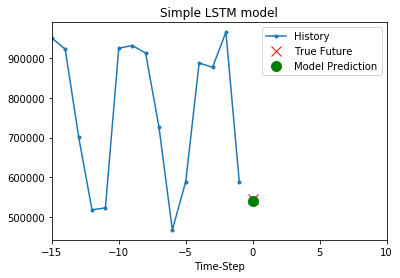

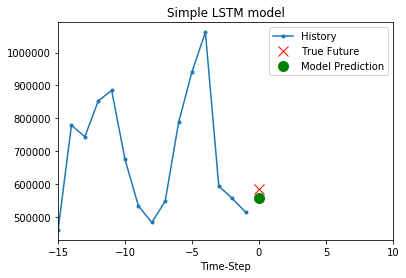

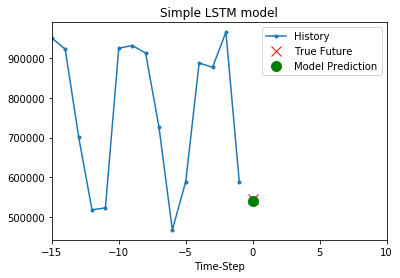

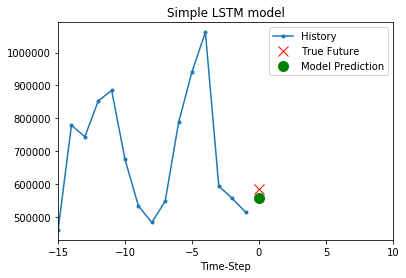

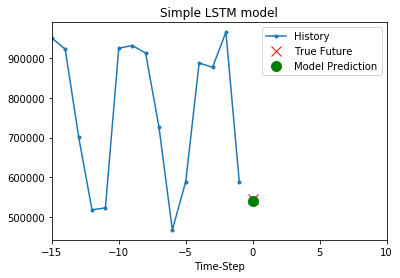

In [300]:
for x, y in val_univariate.take(5):
    y2 = y*uni_train_std + uni_train_mean
    y2_pre = simple_lstm_model.predict(x)*uni_train_std + uni_train_mean
    x2 = x*uni_train_std + uni_train_mean
    
    plot = show_plot([x2[0].numpy(), y2[0].numpy(),
                    y2_pre[0]], 0, 'Simple LSTM model')
    plot.show()

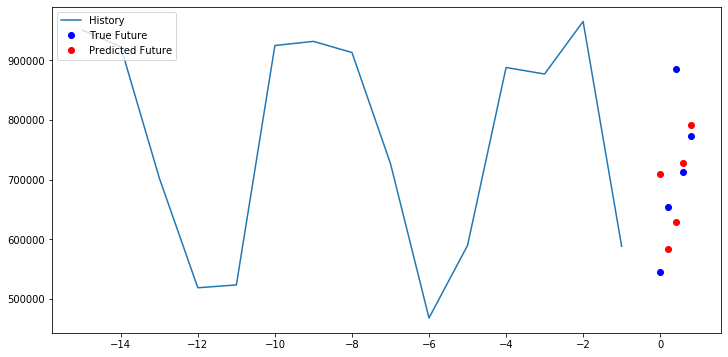

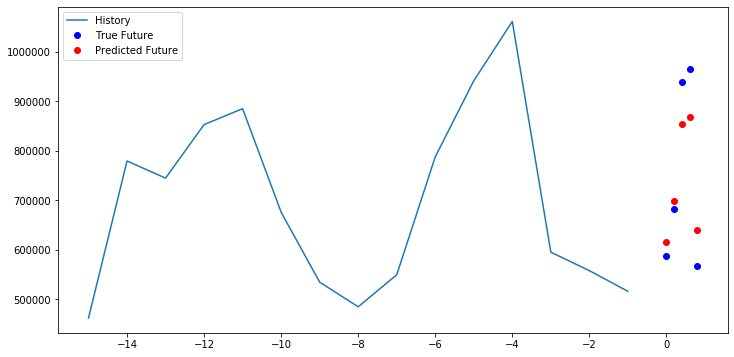

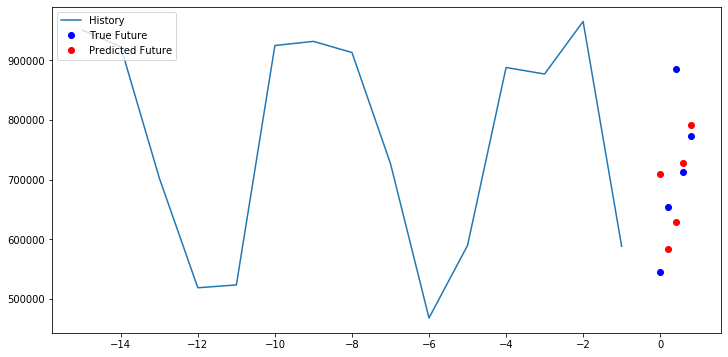

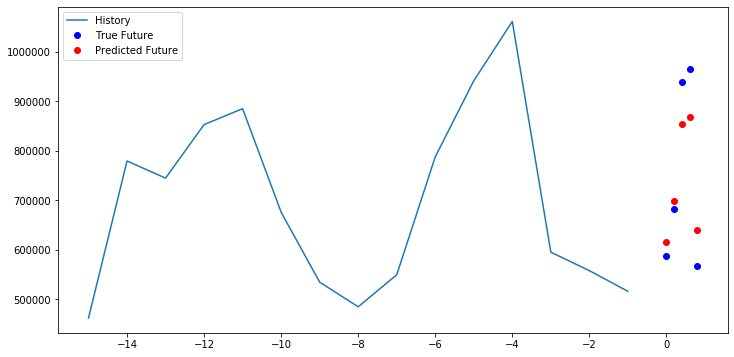

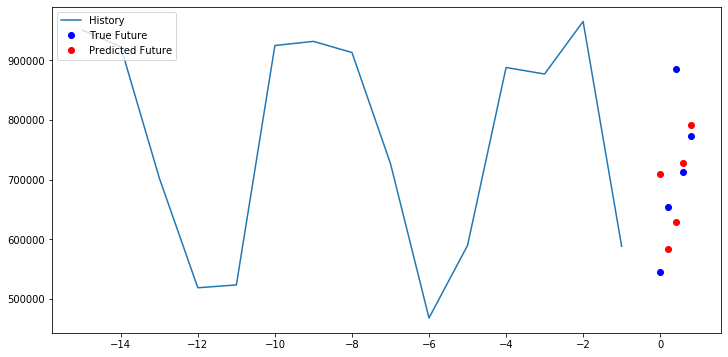

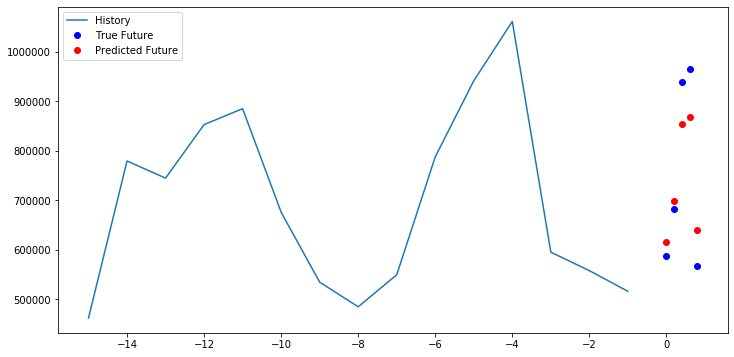

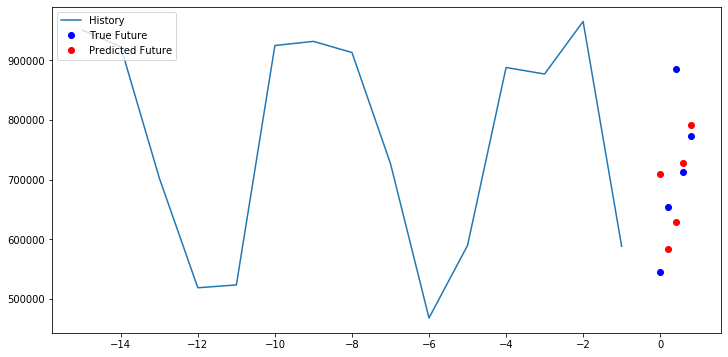

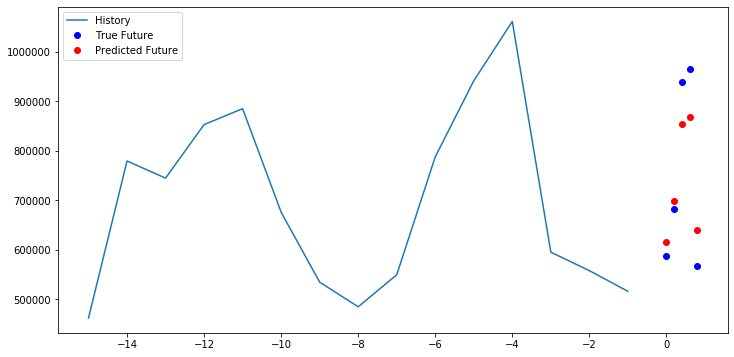

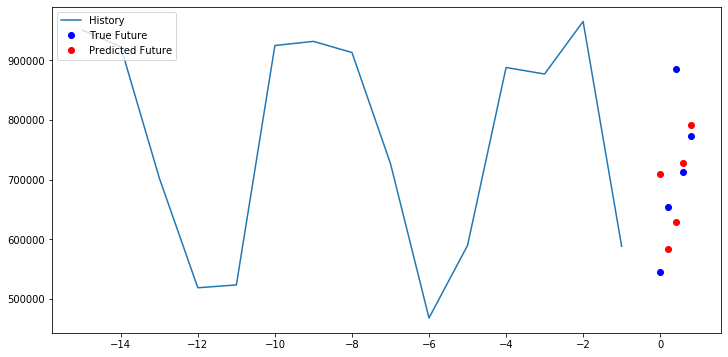

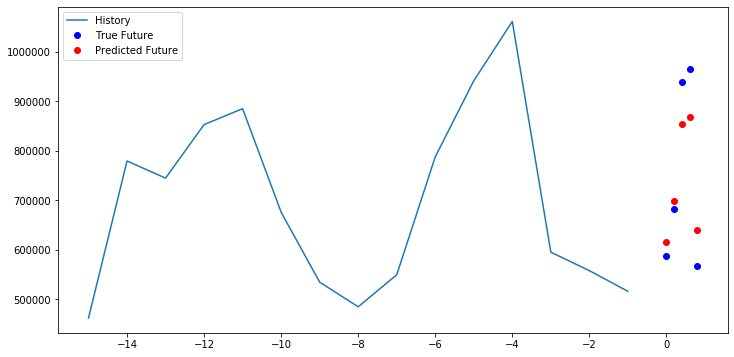

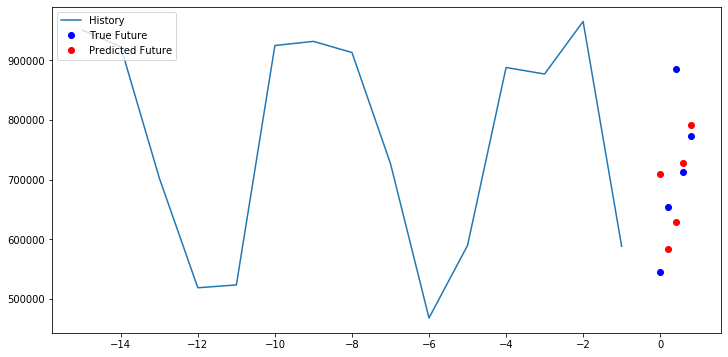

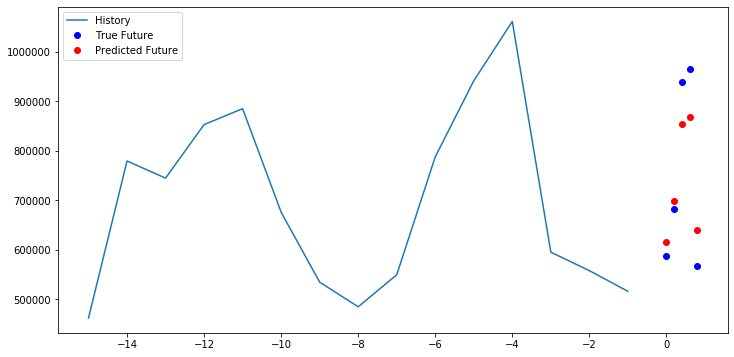

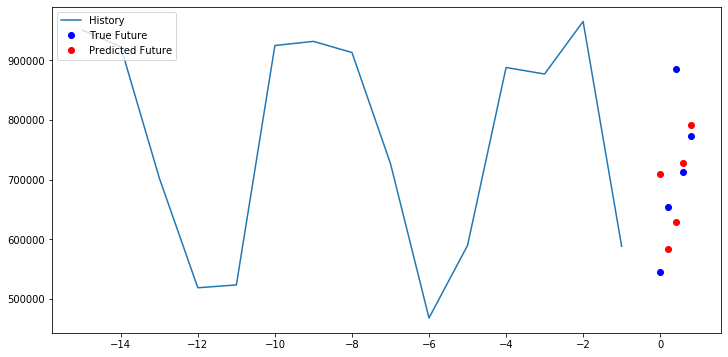

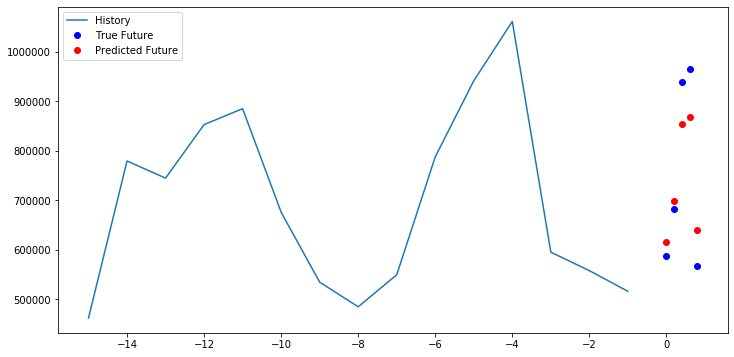

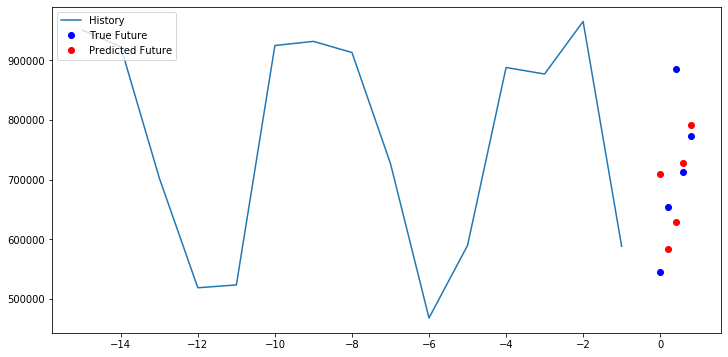

In [311]:
for x, y in val_univariate.take(15):
    y2 = y*uni_train_std + uni_train_mean
    y2_pre = simple_lstm_model.predict(x)*uni_train_std + uni_train_mean
    x2 = x*uni_train_std + uni_train_mean
    
    plot = multi_step_plot(x2[0].numpy(), y2[0].numpy(),y2_pre[0], 5)


In [310]:
def multi_step_plot(history, true_future, prediction, STEP):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()